In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


## 1. Installing required libraries

In [ ]:
!pip install mediapipe

## 1.1 Import the below libraries

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc

## 2. Loading of Dataset from Input folder

In [ ]:
dataset_df = pd.read_csv('/kaggle/input/asl-fingerspelling/supplemental_metadata.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.head()

Given Dataset contains train data in train.csv and corresponding landmark files as parquet files in train_landmarks folder

Each row in train.csv contains path to the corresponding landmarks file of a file id.

phrase and sequence_id is the unique key of the landmark sequence in the landmarks data file.

Each landmark file has data for the landmarks to each unique key combination.

## 2.1 Exploring data in a parquet file 
For the first row of data in the train.csv file i.e., exploring data in the corresponding parquet file of one sequence id

In [ ]:
sequence_id, file_id, phrase = dataset_df.iloc[0][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}")
print(f"file_id: {file_id}")
print(f"phrase: {phrase}")
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/supplemental_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))
sample_sequence_df.head(15)

The sample_sequence_df contains 123 rows of data for each frame and columns are, frame, x_face_0 to x_face_467, x_left_hand_0 to x_left_hand_20, x_pose_0 to x_pose_32, x_right_hand_0 to x_right_hand_20, similarly we have y and z coordinates.

Let us try to visualize the hand coordinates in a 3D view of either left or right hand in the sample_sequence_df data.

In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')
mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils 
mp_drawing_styles = mediapipe.solutions.drawing_styles

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)



def get_hands(seq_df):
    images = []
    all_hand_landmarks = []
    
    for seq_idx in range(len(seq_df)):
        right_hand_image = np.zeros((600, 600, 3))
        left_hand_image = np.zeros((600, 600, 3))

        x_right_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        y_right_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        z_right_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values
        
        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_right_hand, y_right_hand, z_right_hand):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
            right_hand_image,
            right_hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())

        x_left_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        y_left_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        z_left_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values

        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_left_hand, y_left_hand, z_left_hand):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
            left_hand_image,
            left_hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())

        images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
        
    return images, all_hand_landmarks


Fetch and show the data for right hand

In [ ]:
hand_images, hand_landmarks = get_hands(sample_sequence_df) 
create_animation(np.array(hand_images)[:, 0])

## 3. Data pre-processing

[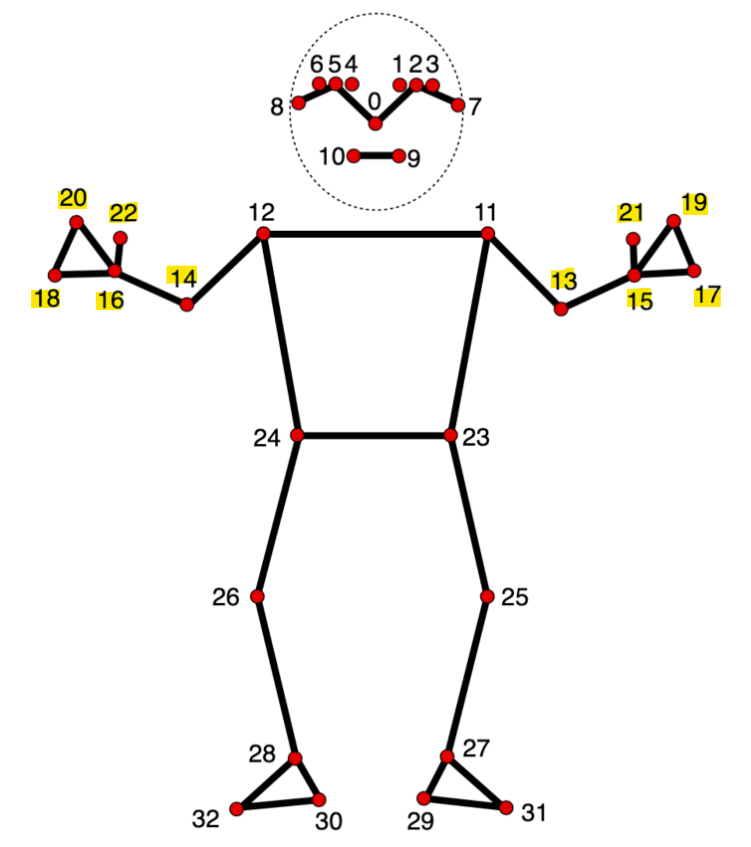]


https://developers.google.com/mediapipe/solutions/vision/pose_landmarker

The highlighted left hand and right hand coordinates are extracted and combining both as pose coordinates in all directions (X, Y and Z) to capture the landmark coordinates in all three dimensions.

## 3.1 Extracting pose coordinates of hands

In [ ]:
# Pose coordinates of hands
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

## 3.2 Extracting X, Y and Z coordinates
We only require the left hand, right hand and pose data in X, Y and Z coordinates and we create feature columns.


In [ ]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]
FEATURE_COLUMNS = X + Y + Z

## 3.3 Storing ids of each coordinate labels to lists


In [101]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]


## 3.4 Writing the dataset as TFRecords
For easy accessing and to optimize performance, we will restructure the data by combining the landmark data and its corresponding phrases within each parquet file.

This eliminates the need to swuitch between train.csv and its associated parquet file for each phrase.

The restructred data is stored in the TFRecord format. TFRecord format is a simple format for storing a sequence of binary records.

### Note: As the dataset is very huge, converting the data into TFRecord Format will take upto 10mins.

In [ ]:
FRAME_LEN = 128

if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

for file_id in tqdm(dataset_df.file_id.unique()):
    pq_file = f"/kaggle/input/asl-fingerspelling/supplemental_landmarks/{file_id}.parquet"
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
    parquet_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/supplemental_landmarks/{str(file_id)}.parquet",
                              columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    tf_file = f"preprocessed/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

Saving the TFRecords generated in the previous step to list.

In [ ]:
tf_records = dataset_df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")




## 3.5 Load character_to_prediction json file
This json file contains a character and its value. We will add three new characters, "<" and ">" to mark the start and end of each phrase, and "P" for padding.

In [ ]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)
    
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}
print(num_to_char)

## 3.6 Detecting of the dominant hand

In [ ]:
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)

        mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
        std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
        hand = (hand - mean) / std

        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)

        x = tf.concat([hand, pose], axis=1)
        x = resize_pad(x)

        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))

    else:
        hand = rhand
        pose = rpose
        
        hand_x = hand[:, 0*(len(RHAND_IDX)//3) : 1*(len(RHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(RHAND_IDX)//3) : 2*(len(RHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(RHAND_IDX)//3) : 3*(len(RHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(RPOSE_IDX)//3) : 1*(len(RPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(RPOSE_IDX)//3) : 2*(len(RPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(RPOSE_IDX)//3) : 3*(len(RPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
        
        hand_x = hand[:, 0*(len(RHAND_IDX)//3) : 1*(len(RHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(RHAND_IDX)//3) : 2*(len(RHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(RHAND_IDX)//3) : 3*(len(RHAND_IDX)//3)]
        hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)

        mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
        std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
        hand = (hand - mean) / std

        pose_x = pose[:, 0*(len(RPOSE_IDX)//3) : 1*(len(RPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(RPOSE_IDX)//3) : 2*(len(RPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(RPOSE_IDX)//3) : 3*(len(RPOSE_IDX)//3)]
        pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)

        x = tf.concat([hand, pose], axis=1)
        x = resize_pad(x)

        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x = tf.reshape(x, (FRAME_LEN, len(RHAND_IDX) + len(RPOSE_IDX)))

    
    return x

## 3.7 Converting TFRecords to Tensors

In [ ]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    landmarks = tf.transpose(landmarks)
    return landmarks, phrase

## 3.8 Data Transformation Function
Data restructuring by transposing landmark coordinates, applying masks, and converting associated phrases into vectorized forms based on character-to-index mappings using character_to_prediction_index.json file.

In [102]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    
    return pre_process(landmarks), phrase

## 4. Splitting of final dataset into test and validation data.

In [103]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

## 5. Creating Transformer model

## 5.1 Define the Transformer Input Layers

When processing landmark coordinate features for the encoder, we apply convolutional layers to downsample them and process local relationships.

We sum position embeddings and token embeddings when processing past target tokens for the decoder.

In [104]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

### 5.1.1 Predefined Positional Encoding

In [105]:
class sineCosinePositionalEncoding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super().__init__()
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.positional_encoding = self.build_positional_encoding()

    def build_positional_encoding(self):
        position = tf.range(self.maxlen, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.embed_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / self.embed_dim))
        pos_enc = position * div_term
        sin_values = tf.sin(pos_enc)
        cos_values = tf.cos(pos_enc)
        pos_enc = tf.stack([tf.reshape(sin_values, [-1]), tf.reshape(cos_values, [-1])], axis=-1)
        pos_enc = tf.reshape(pos_enc, [self.maxlen, self.embed_dim])
        pos_enc = pos_enc[tf.newaxis, ...]
        return tf.cast(pos_enc, dtype=tf.float32)


### 5.1.2 Custom Gaussian Positional Encoding

In [106]:
class CustomGaussianPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super().__init__()
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.positional_encoding = self.build_positional_encoding_gaussian()

    def build_positional_encoding_gaussian(self):
        position = tf.range(self.maxlen, dtype=tf.float32)[:, tf.newaxis]
        sigma = self.maxlen / 6.0 
        gauss_values = tf.exp(-(position - self.maxlen / 2.0)**2 / (2 * sigma**2))

        normalized_gauss = gauss_values / tf.reduce_sum(gauss_values, axis=0)

        pos_enc = tf.reshape(normalized_gauss, [1, self.maxlen, 1])
        pos_enc = tf.tile(pos_enc, [1, 1, self.embed_dim])  
        
        return tf.cast(pos_enc, dtype=tf.float32)


## 5.2 Encoder layer for Transformer

In [107]:
class TransformerEncoderSineCosinePosEncoding(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        maxlen = 100
        self.positional_encoding = sineCosinePositionalEncoding(maxlen, embed_dim)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        inputs = self.positional_encoding(inputs) 
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [108]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        maxlen = 100
        self.positional_encoding = CustomGaussianPositionalEncoding(maxlen, embed_dim)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        inputs = self.positional_encoding(inputs)  
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## 5.3 Decoder layer for Transformer

In [109]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

## 5.4 Complete Transformer model



In [110]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoderSineCosinePosEncoding(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [111]:
class TransformerCustom(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

## 5.5 Function to display predictions

In [112]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 4 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

## 5.6 Train the Transformer model

In [113]:
batch = next(iter(valid_ds))

idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=13)

Epoch 1/13
    455/Unknown - 55s 90ms/step - loss: 1.3082 - edit_dist: 0.9843target:     <tell a lie and your nose will grow>PPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the coure ber an the core bererere>

target:     <the postal service is very slow>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the pringe is are in couring>

target:     <be persistent to win a strike>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <i fof are ar angous the inin>

target:     <space is a high priority>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <a angou the thin the cous the>

target:     <the music is better than it sounds>PPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the ing are a in tous aton>

target:     <if you were not so stupid>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the are are an ane ang tond ce>

target:     <toss the ball around>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <i athis the the the or therere>

target:     <never mix religion and politics>PPPPPPPPPPPPPPPPPPPPPP

## 5.7 Plotting Training and Validation loss

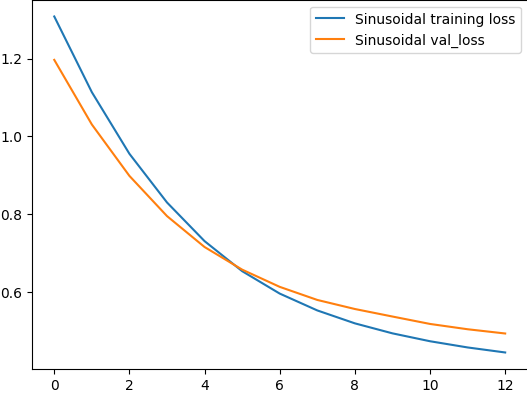

In [114]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Sinusoidal training loss', 'Sinusoidal val_loss'])

In [115]:

loss_data = {
    'Sin TrainLoss': history.history['loss'],
    'Sin ValLoss': history.history['val_loss'],
    'Gaussian TrainLoss': history_.history['loss'],
    'Gaussian ValLoss': history_.history['val_loss']
}

loss_df = pd.DataFrame(loss_data)

print(loss_df)

    Sin TrainLoss  Sin ValLoss  Gaussian TrainLoss  Gaussian ValLoss
0        1.307968     1.196542            1.307973          1.206527
1        1.113609     1.030630            1.122209          1.035775
2        0.955374     0.898629            0.960620          0.900000
3        0.830380     0.795412            0.830412          0.797324
4        0.731084     0.715977            0.729135          0.721921
5        0.654017     0.657936            0.651556          0.663234
6        0.596401     0.613665            0.592270          0.609948
7        0.553138     0.580069            0.547527          0.574521
8        0.519958     0.556806            0.514068          0.550990
9        0.494295     0.537491            0.488610          0.529899
10       0.474025     0.518439            0.468817          0.513736
11       0.458099     0.504827            0.452630          0.499060
12       0.445174     0.493926            0.439904          0.488759


In [116]:


batch = next(iter(valid_ds))

idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
) 

model = TransformerCustom(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer_ = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer_, loss=loss_fn)

history_ = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=13)

Epoch 1/13
    455/Unknown - 31s 40ms/step - loss: 1.3198 - edit_dist: 0.9780target:     <tell a lie and your nose will grow>PPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the four ar than the coure>

target:     <the postal service is very slow>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the are are s an ton and are>

target:     <be persistent to win a strike>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the four ar tha the a an is>

target:     <space is a high priority>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the are a angong the the the>

target:     <the music is better than it sounds>PPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the are a ar ango an tons ton>

target:     <if you were not so stupid>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the are are thas s and toong>

target:     <toss the ball around>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the are as an an the coureres>

target:     <never mix religion and politics>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP


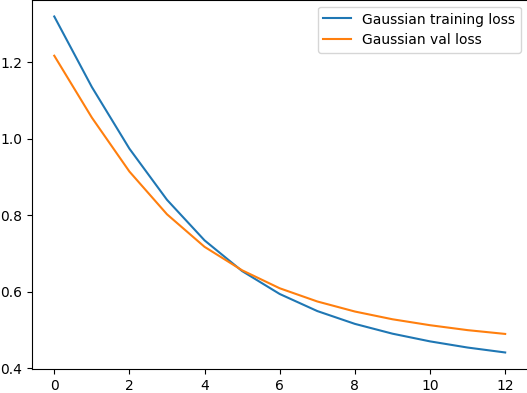

In [117]:
plt.plot(history_.history['loss'])
plt.plot(history_.history['val_loss'])
plt.legend(['Gaussian training loss', 'Gaussian val loss'])